In [1]:
# Importing required packages 
from qiskit import IBMQ, QuantumCircuit, Aer, execute, ClassicalRegister
from qiskit.quantum_info import Operator, Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.algorithms import VQE
import numpy as np
import random, math
from scipy import optimize as opt
import matplotlib.pyplot as plt
from IPython.display import Image
import mitiq

provider = IBMQ.load_account()


C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


The goal of this tutorial is to recreate the Zero Noise Extrapolation (ZNE) results from the article from [N. Klco et al., 2018](https://arxiv.org/abs/1803.03326). In which a VQE is used to find the gound state energy of the Hamiltonian shown below. 


\begin{equation}
H_{k=0,+}^{\lambda^2 = 3} =
\begin{pmatrix}
-2\mu & 2x & 0 & 0\\
2x & 1 & \sqrt{2}x & 0\\
0 & \sqrt{2}x & 2 + 2\mu & \sqrt{2}x \\
0 & 0 & \sqrt{2}x & 3 
\end{pmatrix}
\end{equation}


We utilize qiskit as a backend to allow us to simulate noisy computers with the noise characteristics of their real devices. This tutorial can also serve as a generic guide for ZNE of VQE algorithms, requiring only simple modifications in the case of 4-dimensional hamiltonians. 

The workflow of the tutorial is as it follows

#### Standard VQE
* Evaluate the hamiltonian above for the parameters specified in the paper
    + In case you want to use this for a generic 4x4 Hamiltonian you need only change the Hamiltonian function, or manually input your desired H
    
* Decompose the hamiltonian into the sum of tensor product of pauli matrices (pauli-words) 

* State preparation of the anzats, in this case, we input the one used in the paper 
    + Should you wish to modify the anzats for your own problem only modify the State_Preparation function 
   
* Define measurement basis for the different pauli-words and add measurements to the anzats

* Run the circuit with either a simulator or real device 

* Combining expectation values of pauli-words with decomposition coefficients to obtain the hamiltonian expectation value

* Classical optimization over the free parameters specificied over state preparation to obtain the ground state energy 

#### Mitiq - ZNE
* Creating custom folding function to scale only CNOT gates in the circuit, as specified in the paper 

* Calculating optimal parameters from the optimizatoin and using Mitiq to do ZNE
    + We used the linear factory but any type of inference mehtod can be used

### Standard VQE

In [75]:
def Hamiltonian(mu,x):
    """
    Calculates a numpy array with numerical values for the Hamiltonian defined above

    Parameters
    mu : Float value describing relative mass in the model
    x : Float value describing relative lattice spacing in the model 
    
    Return
    H : 4x4 numpy array with numerical values of the hamiltonian
    HT : 4x4 numpy array with traceless hamiltonian (extracting the terms proportional to the identity)                 
    """       
    
    #Defining array 
    H = np.array([[-2*mu, 2*x, 0, 0],\
                  [2*x, 1, np.sqrt(2)*x, 0],\
                  [0, np.sqrt(2)*x, 2+2*mu, np.sqrt(2)*x],\
                  [0, 0, np.sqrt(2)*x, 3]])
    
    #Eliminating terms proportional to the identity 
    HT = H - (3/2)*np.eye(4)
    
    return H,HT


def Decomposition_H(H):
    """
    Decomposes the previous hamiltonian into the respective pauli matrices (pauli-words) components.
    Uses inner product with the pauli matrices as defined above. 

    Parameters
    H : 4x4 hermitian numpy array 
    
    Return
    c : Dictionary with pauli words as keys and the respective coefficient. 
        eg. {'II': 0, 'IX': 0.32,...}                      
    """
    
    #Definition of the pauli matrices 
    sigma_0 = np.eye(2)
    sigma_X = np.array([[0,1],[1,0]])
    sigma_Y = np.array([[0,-1j],[1j,0]])
    sigma_Z = np.array([[1,0],[0,-1]])
    Pauli = [sigma_0,sigma_X,sigma_Y,sigma_Z]
    Pauli_name = ['I','X','Y','Z']
    
    #Creaiton of the pauli_words (tensor products of pauli matrices)
    ii = 0 
    Poly = []
    Poly_name = []
    for i in Pauli:
        jj = 0
        for j in Pauli:
            Poly.append(np.kron(i,j))
            Poly_name.append(Pauli_name[ii] + Pauli_name[jj])
            jj += 1
        ii += 1
    
    #Doing the partial trace for the coefficinets 
    c = {}
    for i in range(len(Poly)):
        c[Poly_name[i]] = np.real(np.trace(np.matmul(Poly[i],H))/4)
        
    return c



def State_Preparation(theta,r = 1):
    """
    Creates a qiskit quantum circuit with the anzat described in the paper. Doesn't include measurement operations.
    Includes option to scale the CNOT gates manually. 

    Parameters
    theta : 1x3 numpy array with the values of the R_{y} gates defined according to the paper anzats. 
    r : Scaling factor for the CNOT gates, adds 2 CNOT gates representing the Identity gate for each level
        eg. r = 2, adds two gates on the right of each CNOT gate in the circuit
    
    Return
    qc: Qiskit quantum circuit object               
    """
    
    #Start quantum circuit object with 2 qubits
    qc = QuantumCircuit(2)
    
    #Add gates 
    qc.ry(theta[1],0)
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
    
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
        
    qc.ry(theta[2],1)
    
    return qc


def Circuit_Measurement(qc,key):
    """
    Transform the measurement basis according to the description above according to which pauli-word expectation
    value will be calculated. Adds  Measurement to the circuit. 

    Parameters
    qc : Quantum circuit for which expectation value is desired to be calculated
    key : Key describing the pauli-words according to the dictionary defined in 'Decomposition'
          eg. of the form 'IX', 'ZZ', 'YX'.
    
    Return
    qc_state: Qiskit quantum circuit object ready to be executed
    """
    
    qc_state = qc.copy() #save original state of quantum circuit
    qc_state.add_register(ClassicalRegister(2)) #adding of classical registers
    
    #Add pauli gates for different expectation values
    for q in range(2): #Lopp over two qubits
        if key[q] == 'I' or key[q] == 'Z':
            pass
        elif key[q] == 'X':
            qc_state.h(q)
        elif key[q] == 'Y':
            qc_state.sdg(q)
            qc_state.h(q)
                    
    #Add measurement to the circut
    qc_state.measure([0,1], [0,1])
    
    return qc_state


def Expectation_Measurement(qc,key,shots=8192,backend = 'qasm_simulator', noise = False):
    """
    Runs the desired quantum circuit to calculate the expectation of desired polyword according to the description above.
    Allows to run either on a simulated or real machine, with the option of simulating the noise of a real machine. 

    Parameters
    qc : Quantum circuit for which expectation value is desired to be calculated, should have measurements included
    key : Key describing the pauli-words according to the dictionary defined in 'Decomposition'
          eg. of the form 'IX', 'ZZ', 'YX'.
    shots: Number of shots to be used in the experiment
    backend : String containing backend to be used, 'qasm_simulator' simulates withouth running on a real device. In case 
              it is desired to run on a real device include the name of the machine and set noise = False. 
    noise : Parameter used to simulate noise parameters of a real device, should be used with backend = 'qasm simulator'. 
            Input is a string with the machine name. eg. 'ibmq_vigo'
    
    Return
    exp: Float number, the expectatinon value for the desired circuit
    """
           
    if noise == False:
        #Run the noiseless circuit using
        job = execute(
        experiments=qc,
        #backend=provider.get_backend("machine name") to run on hardware
        backend=Aer.get_backend(backend),
        optimization_level=0, shots=shots
        )

    else:
        #Run the circuit with noise parameter of machine
        backend_noise = provider.get_backend(noise)
        noise_model = NoiseModel.from_backend(backend_noise)
        coupling_map = backend_noise.configuration().coupling_map
        basis_gates = noise_model.basis_gates

        job = execute(experiments = qc, backend = Aer.get_backend(backend),
         coupling_map= coupling_map,
         basis_gates=basis_gates,
         noise_model=noise_model,
         optimization_level=0, 
         shots=shots
         )

    #Extract the results counts 
    counts_original = job.result().get_counts()
    counts = {}
    
    #Fix dictionary key of counts (sometimes the dictionary appear with spaces, eg. "I X")
    for key_count in counts_original.keys():
        counts[key_count.replace(" ","")] = counts_original[key_count]
    
    #Insert missing counts in case they're zero
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 
        
    #Evaluate expectation value depending on the basis used
    if key[0] == 'I':
        if key[1] == 'I':            
            # Case + + + +
            exp_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
            exp = exp_counts/shots

        else: 
            # Case + - + - 
            exp_counts = counts['00'] + counts['01'] - counts['10'] - counts['11']
            exp = exp_counts/shots
    else:
        if key[1] == 'I':
            #Case + + - -
            exp_counts = counts['00'] - counts['01'] + counts['10'] - counts['11']
            exp = exp_counts/shots

        else:
            #Case + - - +
            exp_counts = counts['00'] - counts['01'] - counts['10'] + counts['11']
            exp = exp_counts/shots

    return exp


def Expectation_Hamiltonian(qc,H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):
    """
    Calculates energy expectation value through finding the expectation values of individual pauli-words. 

    Parameters
    qc : Quantum circuit for which expectation value is desired to be calculated, should have measurements included
    H: 4x4 hermitian numpy array representin the hamiltonian of the system
    noise : Parameter used to simulate noise parameters of a real device, should be used with backend = 'qasm simulator'. 
            Input is a string with the machine name. eg. 'ibmq_vigo'   
    r : Scaling factor for the CNOT gates, adds 2 CNOT gates representing the Identity gate for each level. Note
        that this is purely for comparative puposes, given that Mitiq automatically implements this. 
        eg. r = 2, adds two gates on the right of each CNOT gate in the circuit 
    shots: Number of shots to be used in the experiment
    backend : String containing backend to be used, 'qasm_simulator' simulates withouth running on a real device. In case 
              it is desired to run on a real device include the name of the machine and set noise = False. 

    Return
    H_exp: Float number, the expectatinon value of the hamiltonian 
    """
    
    #Find the Pauli decomposition
    c = Decomposition_H(H)
    exp_key = c.copy() #copy the dictionary 
    
    #Expectation value initiation    
    H_exp = 0 
    
    #Run expectation measurement for different pauli-words
    for keys in c.keys():
        if c[keys] == 0: #if contribution is zero then skip step
            continue
        
        #Circuit preparation for each key
        qc_key = Circuit_Measurement(qc,keys)
        
        #Run for expectation value
        exp_key[keys] = Expectation_Measurement(qc_key,keys,shots = shots,backend = backend,noise = noise)
        H_exp += c[keys]*exp_key[keys]
    return H_exp


def Optimize(H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):
    """
    Implements scipy minimization of the energy expectation value with respect to the input angles of the 
    state preparation circuit. Utilizes COBYLA method but can be changed if desired. 
    
    Parameters
    H : 4x4 hermitian numpy array representin the hamiltonian of the system
    noise : Parameter used to simulate noise parameters of a real device, should be used with backend = 'qasm simulator'. 
            Input is a string with the machine name. eg. 'ibmq_vigo'
    r : Scaling factor for the CNOT gates, adds 2 CNOT gates representing the Identity gate for each level. Note
        that this is purely for comparative puposes, given that Mitiq automatically implements this. 
        eg. r = 2, adds two gates on the right of each CNOT gate in the circuit 
    shots: Number of shots to be used in the experiment     
    backend : String containing backend to be used, 'qasm_simulator' simulates withouth running on a real device. In case 
              it is desired to run on a real device include the name of the machine and set noise = False. 
    
    Return
    sol: Scipy optimize solution object which contains minumun of function (ground state energy estimation) and the
         theta values that minimize it
    """
    
    #Internal function to make Expectation_Hamiltonian explicitly dependent on theta
    def Expectation_Hamiltonian_theta(theta,Hamiltonian = H,noise=noise,shots = shots, backend = backend, r=r):
        qc_theta = State_Preparation(theta)
        exp_hamiltonian = Expectation_Hamiltonian(qc_theta,Hamiltonian,noise = noise,shots=shots,backend = backend, r=r)
        
        return exp_hamiltonian
    
    #Initial random values
    theta_0 = 2*math.pi*np.random.random([3]) 
    
    #Minimization
    sol = opt.minimize(Expectation_Hamiltonian_theta,theta_0,method='COBYLA', tol=1e-8)
   
    return sol

Below you can test the uses for the different functions defined above

In [83]:
#Values used in the paper minimization
[H,HT] = Hamiltonian(0.1,0.6)

#Analitical eigenvalues of matrix 
eigenH,eigenHT = np.linalg.eig(H);
print('The exact ground state energy is :' + str(eigenH[0]))

#Example dictionary result
coef = Decomposition_H(H)
print(coef)

#Example circuit for state preparation 
qc = State_Preparation([7.27033532, 3.66176275, 1.85667239],r=1)
print(qc)

#Example for circuit to measure 'IX' expectation value
qc_IX = Circuit_Measurement(qc,'ZI')
print(qc_IX)

#Example of expectation value run for quantum circuit IX with parameters in qc
Expectation_IX = Expectation_Measurement(qc_IX,'ZI',noise = False )
print('The expectation value for the IX operator is :' + str(Expectation_IX))

#Example of expectation value for the quantum circuit defined above
Expectation_Ham = Expectation_Hamiltonian(qc,H)
print('The expectation value for the Hamiltonian is :' + str(Expectation_Ham))

#Example of optimization function 
sol = Optimize(H)
print('The VQE minimization yield the result :' + str(sol.fun))

The exact ground state energy is :-1.0116399721069198
{'II': 1.5, 'IX': 1.0242640687119284, 'IY': 0.0, 'IZ': -0.49999999999999994, 'XI': 0.0, 'XX': 0.4242640687119285, 'XY': 0.0, 'XZ': 0.0, 'YI': 0.0, 'YX': 0.0, 'YY': 0.4242640687119285, 'YZ': 0.0, 'ZI': -1.1, 'ZX': 0.17573593128807144, 'ZY': 0.0, 'ZZ': -0.10000000000000009}
     ┌────────────┐                                      
q_0: ┤ RY(3.6618) ├──■──────────────────■────────────────
     ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌────────────┐
q_1: ┤ RY(7.2703) ├┤ X ├┤ RY(7.2703) ├┤ X ├┤ RY(1.8567) ├
     └────────────┘└───┘└────────────┘└───┘└────────────┘
          ┌────────────┐                                      ┌─┐   
     q_0: ┤ RY(3.6618) ├──■──────────────────■────────────────┤M├───
          ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌────────────┐└╥┘┌─┐
     q_1: ┤ RY(7.2703) ├┤ X ├┤ RY(7.2703) ├┤ X ├┤ RY(1.8567) ├─╫─┤M├
          └────────────┘└───┘└────────────┘└───┘└────────────┘ ║ └╥┘
c16396: 2/════════════════════════════

### Mitiq - ZNE

In [100]:
import cirq
from mitiq.conversions import converter
from mitiq.zne.scaling.folding import _fold_gate_at_index_in_moment, deepcopy, _pop_measurements, _cirq_gates_to_string_keys, _append_measurements, squash_moments
from mitiq.zne.inference import *
from functools import partial


@converter
def scale_all_cnot(circuit: cirq.Circuit, scale_factor: float) -> cirq.Circuit:
    
    #Create a circuit copy
    folded = deepcopy(circuit)
    
    measurements = _pop_measurements(folded)
    
    moment_shift = 0
    for (moment_index, moment) in enumerate(circuit):
        for gate_index in range(len(moment)):
            op = circuit[moment_index].operations[gate_index]
            if op.gate == cirq.ops.CNOT:
                for _ in range(int(scale_factor)-1):
                    _fold_gate_at_index_in_moment(
                        folded, moment_index + moment_shift, gate_index
                    )
                    moment_shift += 2
    _append_measurements(folded, measurements)
    folded = squash_moments(folded)
    
    return folded

folded = scale_all_cnot(qc,1)


Below you can test the different folding methods and their differences

In [ ]:
from mitiq.zne.scaling.folding import fold_gates_at_random

#Examples of custom folding vs random folding
qc = State_Preparation([1,2,3])

folded_random = fold_gates_at_random(qc_IX, scale_factor=2)
pr

folded_custom = scale_all_cnot(qc,2)

folded.draw('mpl')

In [102]:
# First get the optimal theta for each of the machines 

noise = [False,
         'ibmq_vigo',
         'ibmq_16_melbourne',
         'ibmq_santiago',
         'ibmqx2'
         ]

shots = 8192


Noise_Scaling_mitiq = [] 

#Obtain a solution with the standard circuit
for n in noise: 
    
    #Define the executor to work with this particular type of noise 
    executor = partial(
        Expectation_Hamiltonian_Mitiq,
        shots = shots,
        noise = n,
                )
    
    #Define factory (Statistical method)
    fac = LinearFactory([1,2,3,4,5,6])
    
    
    #List with results for specific noise
    Noise_extrapolation_mitiq = []
    
    #Obtain solutions for r = 1
    sol = Optimize(H,noise = n)
 

    #Extract values of theta and expectation value
    theta_optimal = sol.x
    

    #Prepare the circuit to be used by mitiq 
    qc = State_Preparation(theta_optimal)

    #Run mitiq optimizer
    zne = mitiq.execute_with_zne(qc,executor, factory = fac,scale_noise=scale_all_cnot) #Executor with cnot gates
    #zne = mitiq.execute_with_zne(qc,executor, factory = fac) #Execturo with random folding
    
    #Save results for respective noise machine
    Noise_extrapolation_mitiq.extend(list(fac.get_expectation_values())) #then saves the calculated expectation values
    Noise_extrapolation_mitiq.insert(0,zne) #saves the zne result    

    Noise_Scaling_mitiq.append(Noise_extrapolation_mitiq) #add to the list of list with each noise



C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


#### Graph of results 

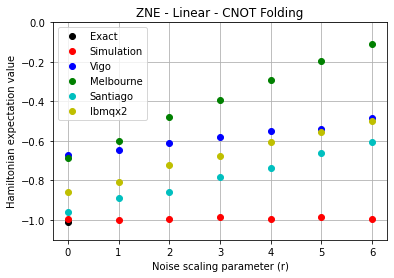

In [113]:


#Extract the results
zne_simulation_mitiq = Noise_Scaling_mitiq[0]
zne_vigo_mitiq = Noise_Scaling_mitiq[1]
zne_melbourne_mitiq = Noise_Scaling_mitiq[2]
zne_santiago_mitiq = Noise_Scaling_mitiq[3]
zne_ibmqx2_mitiq = Noise_Scaling_mitiq[4]

#Results to be stored in a .cvs file 
zne_noextrap  = (zne_simulation_mitiq,zne_vigo_mitiq,zne_melbourne_mitiq,zne_santiago_mitiq,zne_ibmqx2_mitiq)


#Graph results without extrapolation 
labels = [0,1,2,3,4,5,6]

plt.figure()
plt.plot(0,eigenH[0],'ko')
plt.plot(labels,zne_simulation_mitiq,'ro')
plt.plot(labels,zne_vigo_mitiq,'bo')
plt.plot(labels,zne_melbourne_mitiq,'go')
plt.plot(labels,zne_santiago_mitiq,'co')
plt.plot(labels,zne_ibmqx2_mitiq,'yo')
plt.gca().legend(('Exact','Simulation','Vigo','Melbourne','Santiago','Ibmqx2'))


plt.grid()

plt.title('ZNE - Linear - CNOT Folding')
plt.xlabel('Noise scaling parameter (r)')
plt.ylabel('Hamiltonian expectation value')

plt.ylim((-1.1,0))

_=plt.savefig('ZNE_Linear_CNOT.pdf',format = 'pdf'
             ,bbox_inches='tight',dpi=300)


np.savetxt("ZNE_Linear_CNOT",ZNE_Manual, delimiter=",")



In [114]:
from IPython.display import IFrame
IFrame("ZNE_Linear_CNOT", width=600, height=300)